In [2]:
# Import the libraries

import pandas as pd
import numpy as np

import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt 
%matplotlib inline

import re

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.metrics import plot_confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import confusion_matrix

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tag import pos_tag, pos_tag_sents
from nltk.corpus import wordnet

import spacy
from spacy_langdetect import LanguageDetector

import warnings
warnings.filterwarnings("ignore")


Code references: 

https://towardsdatascience.com/sentimental-analysis-using-vader-a3415fef7664

https://towardsdatascience.com/sentiment-analysis-on-amazon-reviews-45cd169447ac


## Data Exploration

In [3]:
df = pd.read_excel('tools_for_data.xlsx')

In [4]:
df

date                                             review  rating  \
0     2021-03-10  Some of the lab instructions are out of synch ...       3   
1     2021-03-10                                 Very nice course.        5   
2     2021-03-10  I have learned much knowledge about data scien...       5   
3     2021-03-08    Clear Idea about the Data Science and its tools       5   
4     2021-03-08  Nice overview, though the course materials hav...       3   
...          ...                                                ...     ...   
3108  2018-09-19  Another Great class.  Really introduces you to...       5   
3109  2018-09-19  Great introduction to the various open source ...       5   
3110  2018-09-19                           Simple trivial materials       3   
3111  2018-09-19                             Very practical course!       5   
3112  2018-09-18         Great Course introducing us to these tools       5   

         status  
0     completer  
1     completer  
2     completer  
3     completer  
4     completer  
...         ...  
3108    dropout  
3109    dropout  
3110    dropout  
3111    dropout  
3112    dropout  

[3113 rows x 4 columns]

In [5]:
df.shape

(3113, 4)

In [6]:
# There seem to be some null values in the review column

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3113 entries, 0 to 3112
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    3113 non-null   object
 1   review  3113 non-null   object
 2   rating  3113 non-null   int64 
 3   status  3113 non-null   object
dtypes: int64(1), object(3)
memory usage: 97.4+ KB


In [7]:
# Check for null values

df.isnull().sum() 

date      0
review    0
rating    0
status    0
dtype: int64

In [8]:
# Drop null values

# df.dropna(inplace = True)

In [9]:
# Count null values in 'review'

# len(df[df['review'].isna()==True])

In [10]:
# df.shape

In [11]:
# Change date column to datetime format

df['date'] = pd.to_datetime(df['date'], errors = 'coerce')

In [12]:
# There are many duplicates in the review column

df.nunique()

date       836
review    2978
rating       5
status       2
dtype: int64

In [13]:
# Top 10 most common reviews

df['review'].value_counts().head(10)  

good                13
Excellent           12
Good                 9
nice                 8
Great                7
very good            7
Excellent Course     7
Good course          7
Very good            6
Great course         5
Name: review, dtype: int64

In [14]:
# duplicates seem to be from different learners

df[(df.review == 'good')]

date review  rating     status
21   2021-02-26   good       4  completer
413  2020-08-17   good       4  completer
537  2020-07-11   good       5  completer
566  2020-07-05   good       5  completer
583  2020-07-02   good       5  completer
813  2020-05-12   good       5  completer
914  2020-04-28   good       5  completer
1003 2020-04-18   good       5  completer
1314 2020-03-03   good       5  completer
1371 2020-02-21   good       5  completer
2386 2019-06-19   good       5  completer
2476 2019-05-29   good       5  completer
2549 2019-05-09   good       4  completer

In [15]:
# We drop duplicate reviews

df = df.drop_duplicates()

In [16]:
# Most reviews have a good rating - the dataset is not balanced, there should be more positive than negative reviews

df['rating'].value_counts()

5    1505
4     715
3     459
2     220
1     214
Name: rating, dtype: int64

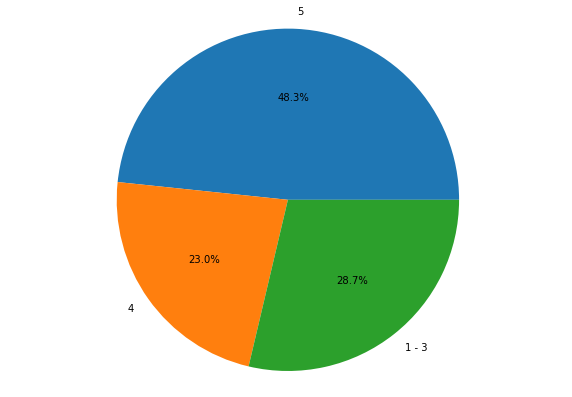

In [17]:
# 48.3.6% of learners have given a rating of 5

plt.figure(figsize =(10, 7)) 
plt.pie([1505, 715, 893], labels = ['5', '4', '1 - 3'], autopct='%1.1f%%');
plt.axis('equal')
plt.show()

In [18]:
# Create column 'length' for number of characters in a review

df['length'] = df['review'].astype(str).apply(len)
df.head()

date                                             review  rating  \
0 2021-03-10  Some of the lab instructions are out of synch ...       3   
1 2021-03-10                                 Very nice course.        5   
2 2021-03-10  I have learned much knowledge about data scien...       5   
3 2021-03-08    Clear Idea about the Data Science and its tools       5   
4 2021-03-08  Nice overview, though the course materials hav...       3   

      status  length  
0  completer     442  
1  completer      18  
2  completer     210  
3  completer      47  
4  completer     450

In [20]:
# The average length of a review is 123 characters - reviews are in general short

df['length'].describe()

count    3113.000000
mean      123.127208
std       160.319241
min         1.000000
25%        35.000000
50%        78.000000
75%       154.000000
max      3257.000000
Name: length, dtype: float64

In [22]:
# The longest reviews have a rating of 1-2. Shortest reviews genrally have a rating of 5. 

px.box(df, x = "rating", y = "length")

In [23]:
# Create new dataframe and remove reviews with less than three characters

df_clean = df[df['length'] > 2]

In [24]:
df_clean['length'].describe()

count    3105.000000
mean      123.441546
std       160.405862
min         3.000000
25%        36.000000
50%        78.000000
75%       155.000000
max      3257.000000
Name: length, dtype: float64

In [25]:
df_clean.shape

(3105, 5)

In [26]:
# Reset the index

df_clean = df_clean.reset_index(drop = True)

In [27]:
df_clean

date                                             review  rating  \
0    2021-03-10  Some of the lab instructions are out of synch ...       3   
1    2021-03-10                                 Very nice course.        5   
2    2021-03-10  I have learned much knowledge about data scien...       5   
3    2021-03-08    Clear Idea about the Data Science and its tools       5   
4    2021-03-08  Nice overview, though the course materials hav...       3   
...         ...                                                ...     ...   
3100 2018-09-19  Another Great class.  Really introduces you to...       5   
3101 2018-09-19  Great introduction to the various open source ...       5   
3102 2018-09-19                           Simple trivial materials       3   
3103 2018-09-19                             Very practical course!       5   
3104 2018-09-18         Great Course introducing us to these tools       5   

         status  length  
0     completer     442  
1     completer      18  
2     completer     210  
3     completer      47  
4     completer     450  
...         ...     ...  
3100    dropout     188  
3101    dropout      75  
3102    dropout      24  
3103    dropout      22  
3104    dropout      42  

[3105 rows x 5 columns]

In [28]:
# Label reviews as positive, negative and neutral depending on their rating

label = []

for row in df_clean['rating']:
    if row == 1 or row == 2:
        label.append('neg')
    elif row == 3:
        label.append('neu')
    else:
        label.append('pos')

In [29]:
df_clean['label'] = label

In [30]:
df_clean.head()

date                                             review  rating  \
0 2021-03-10  Some of the lab instructions are out of synch ...       3   
1 2021-03-10                                 Very nice course.        5   
2 2021-03-10  I have learned much knowledge about data scien...       5   
3 2021-03-08    Clear Idea about the Data Science and its tools       5   
4 2021-03-08  Nice overview, though the course materials hav...       3   

      status  length label  
0  completer     442   neu  
1  completer      18   pos  
2  completer     210   pos  
3  completer      47   pos  
4  completer     450   neu

In [31]:
df_clean['label'].value_counts()

pos    2213
neu     458
neg     434
Name: label, dtype: int64

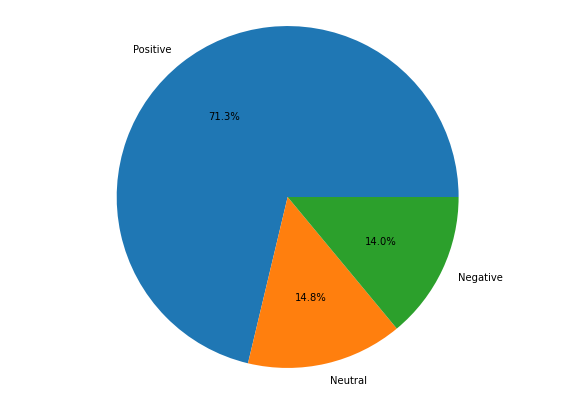

In [34]:
# 71.3 % of the reviews are positive according to the rating

plt.figure(figsize =(10, 7)) 
plt.pie([2213, 458, 434], labels = ['Positive', 'Neutral', 'Negative'], autopct='%1.1f%%');
plt.axis('equal')
plt.show()

In [35]:
# Removing reviews of languages other than English to improve the accuracy of the sentiment classifier

# Define the language detector using spacy

nlp = spacy.load('en_core_web_sm')
nlp.add_pipe(LanguageDetector(), name = 'language_detector', last = True)

In [36]:
# Detect language of reviews

language = []

for row in df_clean['review']:
    doc = nlp(row)
    language.append(doc._.language)


In [37]:
df_clean['language_scores'] = language

In [38]:
df_clean['language_scores']

0        {'language': 'en', 'score': 0.999997056713954}
1       {'language': 'en', 'score': 0.9999965592297603}
2       {'language': 'en', 'score': 0.9999959027806586}
3       {'language': 'en', 'score': 0.9999971743061971}
4       {'language': 'en', 'score': 0.9999962557747355}
                             ...                       
3100    {'language': 'en', 'score': 0.9999935579124668}
3101     {'language': 'en', 'score': 0.999998612574186}
3102    {'language': 'ro', 'score': 0.8571374883983155}
3103    {'language': 'en', 'score': 0.9999940413032389}
3104    {'language': 'en', 'score': 0.9999961500536714}
Name: language_scores, Length: 3105, dtype: object

In [39]:
df_clean['language']  = df_clean['language_scores'].apply(lambda score_dict: score_dict['language'])


In [40]:
df_clean['language'].value_counts()

en         2757
fr           72
es           44
af           36
ca           34
ro           31
so           30
pt           21
de           14
no           13
it            9
pl            9
da            5
nl            5
et            4
fi            4
cy            3
sw            2
cs            2
tr            2
sl            2
vi            1
id            1
UNKNOWN       1
tl            1
sv            1
lv            1
Name: language, dtype: int64

In [67]:
# We only want to keep reviews in English

df_clean[df_clean['language'] == 'da']

date                review  rating     status  length label  \
391  2020-08-25  Struggling, but fun.       5  completer      20   pos   
1604 2020-01-10   I find interesting!       4  completer      19   pos   
1648 2020-01-02         Well designed       5  completer      13   pos   
1888 2019-11-01               Helpful       5    dropout       7   pos   
2134 2019-08-22         very detailed       4  completer      13   pos   

                                      language_scores language  
391   {'language': 'da', 'score': 0.9999949957508449}       da  
1604  {'language': 'da', 'score': 0.5714287279962238}       da  
1648  {'language': 'da', 'score': 0.8571397044382063}       da  
1888  {'language': 'da', 'score': 0.9999923601136739}       da  
2134  {'language': 'da', 'score': 0.8571376246044581}       da

In [68]:
# After checking the language classifications we decide to remove reviews classified as 
# Spanish, Partugese, Turkish, Vietnamese, Danish and UNKNOWN

exclude = ['es','pt', 'tr', 'vi', 'UNKNOWN']

In [69]:
# Remove the reviews with language in list exclude

df_clean = df_clean[~df_clean['language'].isin(exclude)]


In [70]:
df_clean

date                                             review  rating  \
0    2021-03-10  Some of the lab instructions are out of synch ...       3   
1    2021-03-10                                 Very nice course.        5   
2    2021-03-10  I have learned much knowledge about data scien...       5   
3    2021-03-08    Clear Idea about the Data Science and its tools       5   
4    2021-03-08  Nice overview, though the course materials hav...       3   
...         ...                                                ...     ...   
3100 2018-09-19  Another Great class.  Really introduces you to...       5   
3101 2018-09-19  Great introduction to the various open source ...       5   
3102 2018-09-19                           Simple trivial materials       3   
3103 2018-09-19                             Very practical course!       5   
3104 2018-09-18         Great Course introducing us to these tools       5   

         status  length label  \
0     completer     442   neu   
1     completer      18   pos   
2     completer     210   pos   
3     completer      47   pos   
4     completer     450   neu   
...         ...     ...   ...   
3100    dropout     188   pos   
3101    dropout      75   pos   
3102    dropout      24   neu   
3103    dropout      22   pos   
3104    dropout      42   pos   

                                      language_scores language  
0      {'language': 'en', 'score': 0.999997056713954}       en  
1     {'language': 'en', 'score': 0.9999965592297603}       en  
2     {'language': 'en', 'score': 0.9999959027806586}       en  
3     {'language': 'en', 'score': 0.9999971743061971}       en  
4     {'language': 'en', 'score': 0.9999962557747355}       en  
...                                               ...      ...  
3100  {'language': 'en', 'score': 0.9999935579124668}       en  
3101   {'language': 'en', 'score': 0.999998612574186}       en  
3102  {'language': 'ro', 'score': 0.8571374883983155}       ro  
3103  {'language': 'en', 'score': 0.9999940413032389}       en  
3104  {'language': 'en', 'score': 0.9999961500536714}       en  

[3036 rows x 8 columns]

In [71]:
# Reset the index

df_clean = df_clean.reset_index(drop = True)

## VADER Sentiment analysis

Code reference: https://towardsdatascience.com/sentimental-analysis-using-vader-a3415fef7664

In [72]:
# Create a copy of the dataframe

df_vader = df_clean.copy(deep = True)

In [73]:
# Create the vader sentiment calculator 

sid = SentimentIntensityAnalyzer()

In [74]:
# Apply vader to the reviews

df_vader['scores'] = df_vader['review'].apply(lambda review: sid.polarity_scores(review))

df_vader.head()

date                                             review  rating  \
0 2021-03-10  Some of the lab instructions are out of synch ...       3   
1 2021-03-10                                 Very nice course.        5   
2 2021-03-10  I have learned much knowledge about data scien...       5   
3 2021-03-08    Clear Idea about the Data Science and its tools       5   
4 2021-03-08  Nice overview, though the course materials hav...       3   

      status  length label                                  language_scores  \
0  completer     442   neu   {'language': 'en', 'score': 0.999997056713954}   
1  completer      18   pos  {'language': 'en', 'score': 0.9999965592297603}   
2  completer     210   pos  {'language': 'en', 'score': 0.9999959027806586}   
3  completer      47   pos  {'language': 'en', 'score': 0.9999971743061971}   
4  completer     450   neu  {'language': 'en', 'score': 0.9999962557747355}   

  language                                             scores  
0       en  {'neg': 0.075, 'neu': 0.895, 'pos': 0.029, 'co...  
1       en  {'neg': 0.0, 'neu': 0.393, 'pos': 0.607, 'comp...  
2       en  {'neg': 0.0, 'neu': 0.727, 'pos': 0.273, 'comp...  
3       en  {'neg': 0.0, 'neu': 0.755, 'pos': 0.245, 'comp...  
4       en  {'neg': 0.055, 'neu': 0.873, 'pos': 0.072, 'co...

In [75]:
# Extract the compound score from each review

df_vader['compound']  = df_vader['scores'].apply(lambda score_dict: score_dict['compound'])

df_vader.head()

date                                             review  rating  \
0 2021-03-10  Some of the lab instructions are out of synch ...       3   
1 2021-03-10                                 Very nice course.        5   
2 2021-03-10  I have learned much knowledge about data scien...       5   
3 2021-03-08    Clear Idea about the Data Science and its tools       5   
4 2021-03-08  Nice overview, though the course materials hav...       3   

      status  length label                                  language_scores  \
0  completer     442   neu   {'language': 'en', 'score': 0.999997056713954}   
1  completer      18   pos  {'language': 'en', 'score': 0.9999965592297603}   
2  completer     210   pos  {'language': 'en', 'score': 0.9999959027806586}   
3  completer      47   pos  {'language': 'en', 'score': 0.9999971743061971}   
4  completer     450   neu  {'language': 'en', 'score': 0.9999962557747355}   

  language                                             scores  compound  
0       en  {'neg': 0.075, 'neu': 0.895, 'pos': 0.029, 'co...   -0.3818  
1       en  {'neg': 0.0, 'neu': 0.393, 'pos': 0.607, 'comp...    0.4754  
2       en  {'neg': 0.0, 'neu': 0.727, 'pos': 0.273, 'comp...    0.8923  
3       en  {'neg': 0.0, 'neu': 0.755, 'pos': 0.245, 'comp...    0.3818  
4       en  {'neg': 0.055, 'neu': 0.873, 'pos': 0.072, 'co...    0.3400

In [76]:
# We once again label reviews as positive, negative and neutral depending on their compound score

sentiment = []

for row in df_vader['compound']:
    if row < 0:
        sentiment.append('neg')
    elif row > 0:
        sentiment.append('pos')
    else:
        sentiment.append('neu')
        

In [77]:
df_vader['sentiment'] = sentiment

df_vader

date                                             review  rating  \
0    2021-03-10  Some of the lab instructions are out of synch ...       3   
1    2021-03-10                                 Very nice course.        5   
2    2021-03-10  I have learned much knowledge about data scien...       5   
3    2021-03-08    Clear Idea about the Data Science and its tools       5   
4    2021-03-08  Nice overview, though the course materials hav...       3   
...         ...                                                ...     ...   
3031 2018-09-19  Another Great class.  Really introduces you to...       5   
3032 2018-09-19  Great introduction to the various open source ...       5   
3033 2018-09-19                           Simple trivial materials       3   
3034 2018-09-19                             Very practical course!       5   
3035 2018-09-18         Great Course introducing us to these tools       5   

         status  length label  \
0     completer     442   neu   
1     completer      18   pos   
2     completer     210   pos   
3     completer      47   pos   
4     completer     450   neu   
...         ...     ...   ...   
3031    dropout     188   pos   
3032    dropout      75   pos   
3033    dropout      24   neu   
3034    dropout      22   pos   
3035    dropout      42   pos   

                                      language_scores language  \
0      {'language': 'en', 'score': 0.999997056713954}       en   
1     {'language': 'en', 'score': 0.9999965592297603}       en   
2     {'language': 'en', 'score': 0.9999959027806586}       en   
3     {'language': 'en', 'score': 0.9999971743061971}       en   
4     {'language': 'en', 'score': 0.9999962557747355}       en   
...                                               ...      ...   
3031  {'language': 'en', 'score': 0.9999935579124668}       en   
3032   {'language': 'en', 'score': 0.999998612574186}       en   
3033  {'language': 'ro', 'score': 0.8571374883983155}       ro   
3034  {'language': 'en', 'score': 0.9999940413032389}       en   
3035  {'language': 'en', 'score': 0.9999961500536714}       en   

                                                 scores  compound sentiment  
0     {'neg': 0.075, 'neu': 0.895, 'pos': 0.029, 'co...   -0.3818       neg  
1     {'neg': 0.0, 'neu': 0.393, 'pos': 0.607, 'comp...    0.4754       pos  
2     {'neg': 0.0, 'neu': 0.727, 'pos': 0.273, 'comp...    0.8923       pos  
3     {'neg': 0.0, 'neu': 0.755, 'pos': 0.245, 'comp...    0.3818       pos  
4     {'neg': 0.055, 'neu': 0.873, 'pos': 0.072, 'co...    0.3400       pos  
...                                                 ...       ...       ...  
3031  {'neg': 0.0, 'neu': 0.802, 'pos': 0.198, 'comp...    0.8360       pos  
3032  {'neg': 0.0, 'neu': 0.728, 'pos': 0.272, 'comp...    0.6249       pos  
3033  {'neg': 0.355, 'neu': 0.645, 'pos': 0.0, 'comp...   -0.0258       neg  
3034  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...    0.0000       neu  
3035  {'neg': 0.0, 'neu': 0.594, 'pos': 0.406, 'comp...    0.6249       pos  

[3036 rows x 11 columns]

In [78]:
# Using the rating as the measurement for comparison, VADER can classify the reviews correctly as pos/neg/neu with a 91% accuracy

print( 'The accuracy of the sentiment prediction is ', accuracy_score(df_vader.label, sentiment))

The accuracy of the sentiment prediction is  0.6805006587615283


In [81]:
# Save dataframe as a csv file

# df_vader.to_csv('VADER-tools-for-data.csv')

## Data Visualization and Evaluation

Code reference: https://towardsdatascience.com/sentiment-analysis-on-amazon-reviews-45cd169447ac

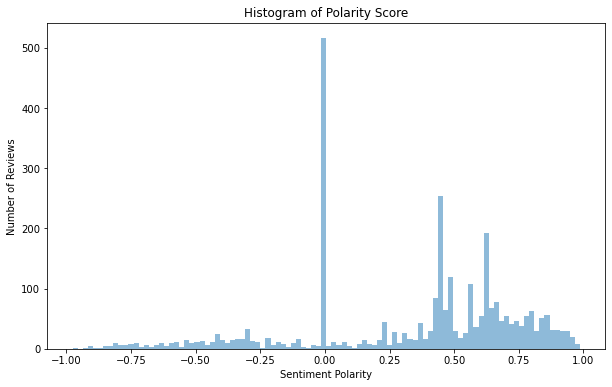

In [82]:
# Histogram of the compound polarity score

num_bins = 100
plt.figure(figsize = (10,6))
n, bins, patches = plt.hist(df_vader.compound, num_bins, alpha = 0.5)
plt.xlabel('Sentiment Polarity')
plt.ylabel('Number of Reviews')
plt.title('Histogram of Polarity Score')
plt.show();

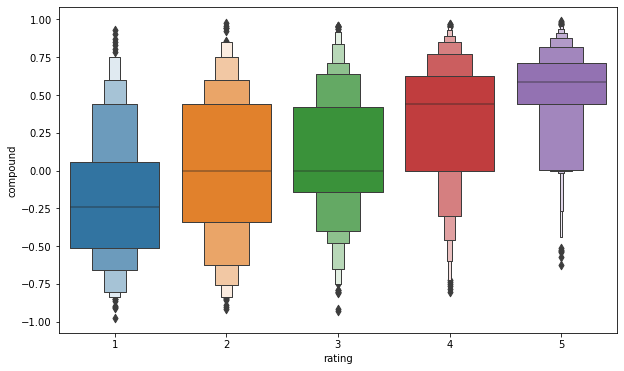

In [83]:
# There are some reviews with a positive sentiment that had a rating of 1 or 2

plt.figure(figsize = (10,6))
sns.boxenplot(x = 'rating', y = 'compound', data = df_vader)
plt.show();

In [84]:
# Reviewing reviews with a negative sentiment 
# it seems that some reviews have been rated incorrectly by the learner, but also that VADER
# has problems classifying the sentiment correctly

df_vader[(df_vader["sentiment"] == "neg")]

date                                             review  rating  \
0    2021-03-10  Some of the lab instructions are out of synch ...       3   
6    2021-03-06  There were some parts. It's too much details a...       3   
8    2021-03-05  some jargon difficult for newcomers to this field       4   
9    2021-03-04  Too basic info, and a whole host of shameless ...       1   
12   2021-03-02  Very patchy. Some of the videos were quite inf...       2   
...         ...                                                ...     ...   
2993 2018-10-15  The videos are outdated, and the final assignm...       1   
2999 2018-10-12  Awful course. IBM Watson Studio, the platform ...       1   
3008 2018-10-05  Don't take it. No Course Instructors, no help....       1   
3014 2018-10-02  I fully satisfied this course, but I had a pro...       4   
3033 2018-09-19                           Simple trivial materials       3   

         status  length label  \
0     completer     442   neu   
6     completer     155   neu   
8     completer      49   pos   
9     completer     330   neg   
12    completer     541   neg   
...         ...     ...   ...   
2993    dropout     159   neg   
2999  completer     189   neg   
3008    dropout     139   neg   
3014    dropout     276   pos   
3033    dropout      24   neu   

                                      language_scores language  \
0      {'language': 'en', 'score': 0.999997056713954}       en   
6     {'language': 'en', 'score': 0.9999950418548255}       en   
8     {'language': 'en', 'score': 0.9999965688204738}       en   
9     {'language': 'en', 'score': 0.9999979112756167}       en   
12    {'language': 'en', 'score': 0.9999958699054043}       en   
...                                               ...      ...   
2993  {'language': 'en', 'score': 0.9999970243696299}       en   
2999  {'language': 'en', 'score': 0.9999966086547492}       en   
3008  {'language': 'en', 'score': 0.9999975331280087}       en   
3014  {'language': 'en', 'score': 0.9999973812434456}       en   
3033  {'language': 'ro', 'score': 0.8571374883983155}       ro   

                                                 scores  compound sentiment  
0     {'neg': 0.075, 'neu': 0.895, 'pos': 0.029, 'co...   -0.3818       neg  
6     {'neg': 0.094, 'neu': 0.906, 'pos': 0.0, 'comp...   -0.4201       neg  
8     {'neg': 0.263, 'neu': 0.737, 'pos': 0.0, 'comp...   -0.3612       neg  
9     {'neg': 0.159, 'neu': 0.766, 'pos': 0.075, 'co...   -0.6486       neg  
12    {'neg': 0.073, 'neu': 0.927, 'pos': 0.0, 'comp...   -0.7690       neg  
...                                                 ...       ...       ...  
2993  {'neg': 0.078, 'neu': 0.922, 'pos': 0.0, 'comp...   -0.2755       neg  
2999  {'neg': 0.144, 'neu': 0.773, 'pos': 0.083, 'co...   -0.2960       neg  
3008  {'neg': 0.225, 'neu': 0.617, 'pos': 0.157, 'co...   -0.2448       neg  
3014  {'neg': 0.149, 'neu': 0.814, 'pos': 0.037, 'co...   -0.7354       neg  
3033  {'neg': 0.355, 'neu': 0.645, 'pos': 0.0, 'comp...   -0.0258       neg  

[432 rows x 11 columns]

In [85]:
# Creating a dataframe for the reviews with a negative sentiment

neg_reviews = df_vader[(df_vader["sentiment"] == "neg")]

In [87]:
# Negative reviews only classified with a 46% accuracy using the rating as the measurement
# This number is very low

print( 'The accuracy of the negative sentiment prediction is ', accuracy_score(neg_reviews.label, neg_reviews.sentiment))

The accuracy of the negative sentiment prediction is  0.46064814814814814


In [88]:
# Dataframe with reviews with a negative rating

neg_label = df_vader[(df_vader["label"] == "neg")]

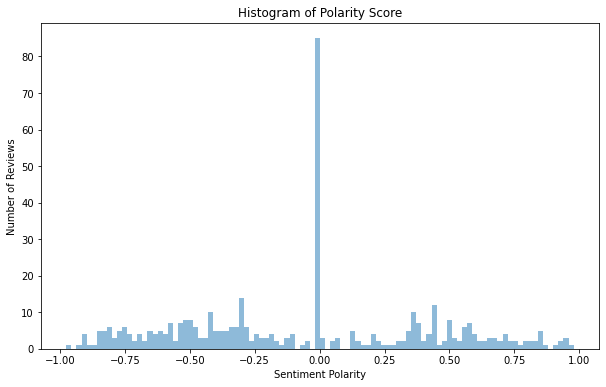

In [89]:
# Histogram of the compound polarity score of of reviews with a negative rating

num_bins = 100
plt.figure(figsize = (10,6))
n, bins, patches = plt.hist(neg_label.compound, num_bins, alpha = 0.5)
plt.xlabel('Sentiment Polarity')
plt.ylabel('Number of Reviews')
plt.title('Histogram of Polarity Score')
plt.show();

In [90]:
# Reviewing reviews with a positive sentiment 

df_vader[(df_vader["sentiment"] == "pos")]

date                                             review  rating  \
1    2021-03-10                                 Very nice course.        5   
2    2021-03-10  I have learned much knowledge about data scien...       5   
3    2021-03-08    Clear Idea about the Data Science and its tools       5   
4    2021-03-08  Nice overview, though the course materials hav...       3   
5    2021-03-07  A great introductory course to learn entire ec...       5   
...         ...                                                ...     ...   
3029 2018-09-20  the ibm watson lab was a great experience indeed.       5   
3030 2018-09-20  The course is OK, the problem is that IBM tool...       3   
3031 2018-09-19  Another Great class.  Really introduces you to...       5   
3032 2018-09-19  Great introduction to the various open source ...       5   
3035 2018-09-18         Great Course introducing us to these tools       5   

         status  length label  \
1     completer      18   pos   
2     completer     210   pos   
3     completer      47   pos   
4     completer     450   neu   
5     completer      86   pos   
...         ...     ...   ...   
3029    dropout      49   pos   
3030    dropout     241   neu   
3031    dropout     188   pos   
3032    dropout      75   pos   
3035    dropout      42   pos   

                                      language_scores language  \
1     {'language': 'en', 'score': 0.9999965592297603}       en   
2     {'language': 'en', 'score': 0.9999959027806586}       en   
3     {'language': 'en', 'score': 0.9999971743061971}       en   
4     {'language': 'en', 'score': 0.9999962557747355}       en   
5     {'language': 'en', 'score': 0.9999973606606977}       en   
...                                               ...      ...   
3029  {'language': 'en', 'score': 0.9999990043457156}       en   
3030  {'language': 'en', 'score': 0.9999965417993364}       en   
3031  {'language': 'en', 'score': 0.9999935579124668}       en   
3032   {'language': 'en', 'score': 0.999998612574186}       en   
3035  {'language': 'en', 'score': 0.9999961500536714}       en   

                                                 scores  compound sentiment  
1     {'neg': 0.0, 'neu': 0.393, 'pos': 0.607, 'comp...    0.4754       pos  
2     {'neg': 0.0, 'neu': 0.727, 'pos': 0.273, 'comp...    0.8923       pos  
3     {'neg': 0.0, 'neu': 0.755, 'pos': 0.245, 'comp...    0.3818       pos  
4     {'neg': 0.055, 'neu': 0.873, 'pos': 0.072, 'co...    0.3400       pos  
5     {'neg': 0.0, 'neu': 0.745, 'pos': 0.255, 'comp...    0.6249       pos  
...                                                 ...       ...       ...  
3029  {'neg': 0.0, 'neu': 0.631, 'pos': 0.369, 'comp...    0.6249       pos  
3030  {'neg': 0.059, 'neu': 0.877, 'pos': 0.064, 'co...    0.0601       pos  
3031  {'neg': 0.0, 'neu': 0.802, 'pos': 0.198, 'comp...    0.8360       pos  
3032  {'neg': 0.0, 'neu': 0.728, 'pos': 0.272, 'comp...    0.6249       pos  
3035  {'neg': 0.0, 'neu': 0.594, 'pos': 0.406, 'comp...    0.6249       pos  

[2091 rows x 11 columns]

In [91]:
# Creating a dataframe for the reviews with a positive sentiment

pos_reviews = df_vader[(df_vader["sentiment"] == "pos")]

In [93]:
# Positive reviews are classified with a 83% accuracy using the rating as the measurement

print( 'The accuracy of the positive sentiment prediction is ', accuracy_score(pos_reviews.label, pos_reviews.sentiment))

The accuracy of the positive sentiment prediction is  0.8345289335246293


In [94]:
# Dataframe with reviews with a positive rating

pos_label = df_vader[(df_vader["label"] == "pos")]

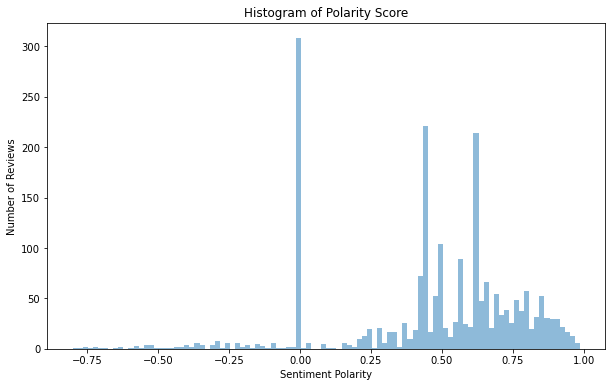

In [95]:
# Histogram of the compound polarity score of reviews with a positive rating

num_bins = 100
plt.figure(figsize = (10,6))
n, bins, patches = plt.hist(pos_label.compound, num_bins, alpha = 0.5)
plt.xlabel('Sentiment Polarity')
plt.ylabel('Number of Reviews')
plt.title('Histogram of Polarity Score')
plt.show();

In [96]:
# Reviewing reviews with a neutral sentiment  

df_vader[(df_vader["sentiment"] == "neu")]

date                                             review  rating  \
21   2021-02-26                               I learned A LOT!!!!!       5   
29   2021-02-20            Really ejoyed Labs and practical tasks.       4   
43   2021-02-13                                Small parts of labs       3   
47   2021-02-09  Too much information thrown at you with little...       3   
50   2021-02-07  Getting an overview of all the tools available...       5   
...         ...                                                ...     ...   
3004 2018-10-07      Names of sites mentioned needs to be updated.       4   
3007 2018-10-06                              Exactly what you need       5   
3021 2018-09-28                                     So many tools        4   
3022 2018-09-26  Sites look different now and the video lecture...       2   
3034 2018-09-19                             Very practical course!       5   

         status  length label  \
21    completer      20   pos   
29    completer      39   pos   
43    completer      19   neu   
47      dropout     158   neu   
50    completer     122   pos   
...         ...     ...   ...   
3004  completer      45   pos   
3007  completer      21   pos   
3021    dropout      14   pos   
3022    dropout     125   neg   
3034    dropout      22   pos   

                                      language_scores language  \
21    {'language': 'en', 'score': 0.9999980686185188}       en   
29    {'language': 'en', 'score': 0.9999979653573576}       en   
43    {'language': 'en', 'score': 0.9999977688205397}       en   
47    {'language': 'en', 'score': 0.9999974064161392}       en   
50    {'language': 'en', 'score': 0.9999969735024659}       en   
...                                               ...      ...   
3004  {'language': 'en', 'score': 0.9999961777799384}       en   
3007   {'language': 'en', 'score': 0.999997159765164}       en   
3021  {'language': 'en', 'score': 0.9999967058392907}       en   
3022  {'language': 'en', 'score': 0.9999978298705365}       en   
3034  {'language': 'en', 'score': 0.9999940413032389}       en   

                                                 scores  compound sentiment  
21    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...       0.0       neu  
29    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...       0.0       neu  
43    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...       0.0       neu  
47    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...       0.0       neu  
50    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...       0.0       neu  
...                                                 ...       ...       ...  
3004  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...       0.0       neu  
3007  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...       0.0       neu  
3021  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...       0.0       neu  
3022  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...       0.0       neu  
3034  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...       0.0       neu  

[513 rows x 11 columns]

In [97]:
# Creating a dataframe for the reviews with a neutral sentiment

neu_reviews = df_vader[(df_vader["sentiment"] == "neu")]

In [101]:
# Neutral reviews are classified with a 23% accuracy using the rating as the measurement
# This number is very low

print( 'The accuracy of the positive sentiment prediction is ', accuracy_score(neu_reviews.label, neu_reviews.sentiment))


The accuracy of the positive sentiment prediction is  0.2378167641325536


In [102]:
# Creating dataframe for reviews with a neutral rating

neu_label = df_vader[(df_vader["label"] == "neu")]

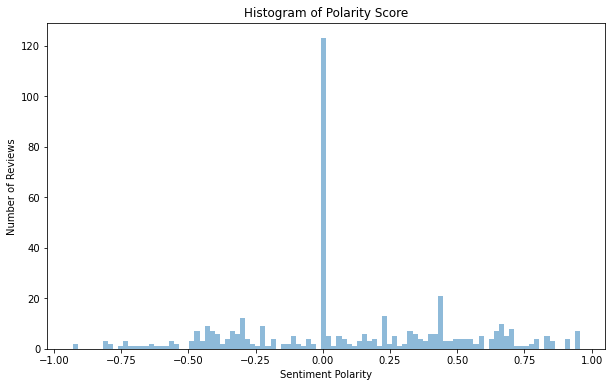

In [103]:
# Histogram of the compound polarity score of reviews with a neutral rating

num_bins = 100
plt.figure(figsize = (10,6))
n, bins, patches = plt.hist(neu_label.compound, num_bins, alpha = 0.5)
plt.xlabel('Sentiment Polarity')
plt.ylabel('Number of Reviews')
plt.title('Histogram of Polarity Score')
plt.show();